# LOAD MODEL

In [1]:
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
from nnunetv2.training.nnUNetTrainer.variants.pathology.nnUNetTrainer_custom_dataloader_test import nnUNetTrainer_custom_dataloader_test
from nnunetv2.utilities.file_path_utilities import load_json
import torch
from nnunetv2.inference.sliding_window_prediction import compute_gaussian, predict_sliding_window_return_logits

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/data/nnUNet_raw
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/data/nnUNet_preprocessed
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.
INSTEAD USING HARDCODED: /data/pathology/projects/pathology-lung-TIL/nn

In [3]:
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"

def convert_path(path, to=current_os):
    if to in ["w", "win", "windows"]:
        path = path.replace("/mnt/pa_cpg", "Y:")
        path = path.replace("/data/pathology", "Z:")
        path = path.replace("/mnt/pa_cpgarchive1", "W:")
        path = path.replace("/mnt/pa_cpgarchive2", "X:")
        path = path.replace("/", "\\")
    if to in ["u", "unix", "l", "linux"]:
        path = path.replace("Y:", "/mnt/pa_cpg")
        path = path.replace("Z:", "/data/pathology")
        path = path.replace("W:", "/mnt/pa_cpgarchive1")
        path = path.replace("X:", "/mnt/pa_cpgarchive2")
        path = path.replace("\\", "/")
    return path

# trainer initialization prep

### Set results folder

In [4]:
results_folder = convert_path(r'Z:\projects\pathology-lung-TIL\nnUNet_v2\data\nnUNet_results')

In [5]:
os.listdir(results_folder)

['Dataset004_TIGER_split', 'Dataset001_TIGER_split']

### Choose dataset

In [6]:
dataset = 'Dataset004_TIGER_split'

In [7]:
os.listdir(os.path.join(results_folder, dataset))

['nnUNetTrainer_custom_dataloader_test__nnUNetWholeSlideDataPlans__2d']

### Choose trainer__plans__config

In [8]:
trainer__plans__config = 'nnUNetTrainer_custom_dataloader_test__nnUNetWholeSlideDataPlans__2d'

In [9]:
trainer_results_folder = os.path.join(results_folder, dataset, trainer__plans__config)

In [10]:
os.listdir(trainer_results_folder)

['train_config.json',
 'fold_0',
 'plans.json',
 'splits.json',
 'dataset.json',
 'val_config.json']

### Choose fold

In [11]:
fold = 0

In [12]:
[file for file in os.listdir(os.path.join(trainer_results_folder, f'fold_{fold}')) if file.endswith('.pth')]

['checkpoint_best.pth', 'checkpoint_latest.pth']

### Choose checkpoint

In [13]:
checkpoint_path = os.path.join(trainer_results_folder, f'fold_{fold}', 'checkpoint_best.pth')

### Get plans and dataset dicts

In [14]:
plans_dict = load_json(os.path.join(trainer_results_folder, 'plans.json'))
dataset_dict = load_json(os.path.join(trainer_results_folder, 'dataset.json'))

# Directly import class and initialize checkpoint

In [15]:
trainer = nnUNetTrainer_custom_dataloader_test(plans_dict, '2d', fold, dataset_dict)

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################



In [16]:
trainer.load_checkpoint(checkpoint_path)

# Get dataloaders

In [17]:
tr_it, val_it = trainer.get_dataloaders(temp=True)

Found splits.json
[Getting WSD dataloaders]
Using iterator template: /data/pathology/projects/pathology-lung-TIL/nnUNet_v2/nnunetv2/training/nnUNetTrainer/variants/pathology/wsd_iterator_alb_aug_template.json
Still timing everything, only copying SOME training and val files
[Creating batch iterators]
	[Creating TRAIN batch iterator]
	[Creating VAL batch iterator]
[Returning batch iterators]


### Get data

In [104]:
data = next(val_it)

In [105]:
data['data'] = data['data'][..., :512, :512]
data['target'][0] = data['target'][0][..., :512, :512]

In [106]:
labels = {
    "roi": 0, # in case 0 is true background instead of unannotated, make sure you add it as label 1, not 0. Since label 0 will not be used for counting
    "invasive tumor": 1,
    "tumor-associated stroma": 2,
    "in-situ tumor": 3 ,
    "healthy glands": 4,
    "necrosis not in-situ": 5,
    "inflamed stroma": 6,
    "rest": 7
}

colormap = [ [ 0, 0, 0, 0 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]
colormap = np.array(colormap)/255.
cmap = LinearSegmentedColormap.from_list('my_cmap', colors=colormap)

label_names = ['unannotated'] + list(labels.keys())[1:]
label_index = list(range(len(label_names)))
n_labels = len(label_names)
label_plot_args = {"cmap":cmap, "vmin":0, "vmax":255, "interpolation":"none"}

In [107]:
%matplotlib inline

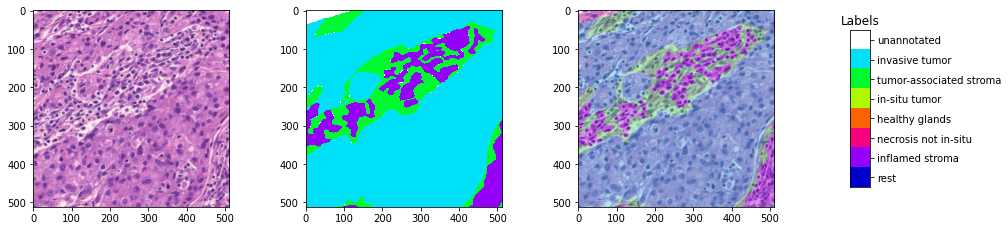

In [108]:
# left is meant to be empty. its just easy to copy paste in figures this way
fig, axs = plt.subplots(1, 4, figsize=(15, 4), gridspec_kw={'width_ratios': [10, 10, 10, 1], 'wspace': 0.5})
axs[0].imshow(data['data'][0].permute((1, 2, 0)).cpu())
axs[1].imshow(data['target'][0][0][0].cpu(), **label_plot_args)
axs[2].imshow(data['data'][0].permute((1, 2, 0)).cpu())
axs[2].imshow(data['target'][0][0][0].cpu(), alpha=0.3, **label_plot_args)
axs[-1].imshow([[i] for i in list(range(len(label_names)))], **label_plot_args)
axs[-1].set_yticks(label_index)
axs[-1].set_yticklabels(label_names)
axs[-1].yaxis.tick_right()
axs[-1].get_xaxis().set_visible(False)
axs[-1].set_title("Labels")
plt.show()

# Prep Gaussian inference map and run sliding window on data

In [109]:
inference_gaussian = torch.from_numpy(
    compute_gaussian(
        trainer.configuration_manager.patch_size, 
        sigma_scale=1. / 8))

In [110]:
# data = next(val_it)

In [111]:
data['data'].shape

torch.Size([17, 3, 512, 512])

In [112]:
data = data['data'][..., :512, :512][:2] #.permute((1, 0, 2, 3))

In [113]:
data.shape

torch.Size([2, 3, 512, 512])

In [114]:
torch.cuda.empty_cache()
out = trainer.network(data)

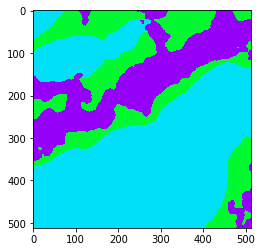

In [116]:
plt.imshow(torch.argmax(out[0][0], 0).cpu(), **label_plot_args)

In [57]:
torch.concat(out).shape

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 512 but got size 256 for tensor number 1 in the list.

In [44]:
pred = predict_sliding_window_return_logits(
    trainer.network, 
    data['data'], 
    trainer.label_manager.num_segmentation_heads,
    tile_size=trainer.configuration_manager.patch_size,
    mirror_axes=trainer.inference_allowed_mirroring_axes,
    tile_step_size=0.5,
    use_gaussian=True,
    precomputed_gaussian=inference_gaussian,
    perform_everything_on_gpu=True,
    verbose=True,
    device=trainer.device).cpu().numpy()

step_size: 0.5
mirror_axes: None
n_steps 27, image size is torch.Size([3, 1024, 1024]), tile_size [512, 512], tile_step_size 0.5
steps:
[[0, 256, 512], [0, 256, 512]]


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 17, 512, 512] to have 3 channels, but got 17 channels instead

In [45]:
prediction = predict_sliding_window_return_logits(self.network, data, num_seg_heads,
                                                                      tile_size=self.configuration_manager.patch_size,
                                                                      mirror_axes=self.inference_allowed_mirroring_axes,
                                                                      tile_step_size=0.5,
                                                                      use_gaussian=True,
                                                                      precomputed_gaussian=inference_gaussian,
                                                                      perform_everything_on_gpu=True,
                                                                      verbose=False,
                                                                      device=self.device).cpu().numpy()

NameError: name 'self' is not defined

In [ ]:
trainer.network

In [ ]:
# # RUN trainer EXPORT, doesnt work...

# trainer, plans, config = trainer__plans__config.split('__')
# folds = (0,)
# checkpoint = ('checkpoint_best.pth',)
# output_filename = 'trainer_export_test.zip'


# export_pretrained_trainer(dataset_name_or_id = dataset, 
#                         output_file = output_filename,
#                         configurations = ("2d", ),
#                         trainer = trainer,
#                         plans_identifier  = plans,
#                         folds = folds,
#                         strict = True,
#                         save_checkpoints = checkpoint,
#                         export_crossval_predictions = False)